In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import eli5
from eli5.sklearn import PermutationImportance

import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK
import ast

Using TensorFlow backend.


In [2]:
#Data comes from TMDB Box Office Prediction on Kaggle.com
train = pd.read_csv('./TMDB_pred/train.csv')
test = pd.read_csv('./TMDB_pred/test.csv')

## Data overview

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

In [5]:
train.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


__Check missing values in data__

In [6]:
train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [7]:
test.isna().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

__Target Variable Distribution__

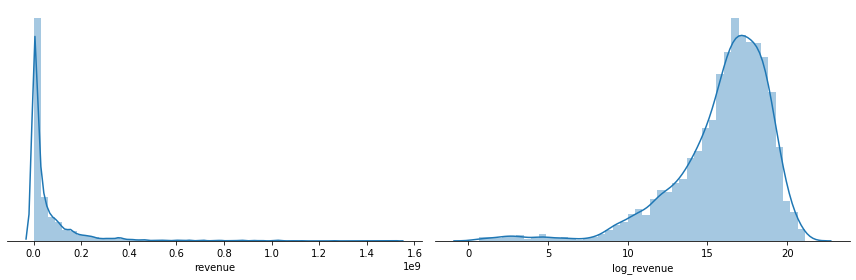

In [8]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.despine(left=True)

sns.distplot(train['revenue'], ax=axes[0], axlabel='revenue')
sns.distplot(np.log1p(train['revenue']), ax=axes[1], axlabel='log_revenue')
plt.setp(axes, yticks=[])
plt.tight_layout()

## Clean data

In [9]:
train.loc[849, 'budget'] = 1500000      #Modern Times
train.loc[796, 'budget'] = 8000000      #Welcome to Dongmakgol
train.loc[2695, 'budget'] = 10000000    #Nurse 3-D
train.loc[512, 'budget'] = 1100000      #From Prada to Nada
train.loc[469, 'budget'] = 13000000     #The Karate Kid, Part II
train.loc[2251, 'budget'] = 7934136     #Bodyguard
train.loc[2610, 'budget'] = 1200000     #The Tiger: An Old Hunter's Tale
train.loc[2645, 'budget'] = 4230000     #My Old Classmate
train.loc[8, 'budget'] = 31000000       #Muppet Treasure Island
train.loc[89, 'budget'] = 30000000      #Sommersby
train.loc[117, 'budget'] = 60000000     #Wild Hogs
train.loc[126, 'budget'] = 9000000      #Corvette Summer
train.loc[141, 'budget'] = 12500000     #Girl with a Pearl Earring
train.loc[148, 'budget'] = 18000000     #Beethoven
train.loc[383, 'budget'] = 40000000     #Anna Karenina
train.loc[416, 'budget'] = 25000000      #Departures
train.loc[465, 'budget'] = 14500000     #Suspect
train.loc[669, 'budget'] = 30000000      #Father of the Bride Part II
train.loc[818, 'budget'] = 90000000      #Alvin and the Chipmunks: The Road Chip
train.loc[876, 'budget'] = 20000000      #White Nights
train.loc[885, 'budget'] = 12000000      #Revenge of the Pink Panther
train.loc[915, 'budget'] = 20000000      #Rurouni Kenshin
train.loc[1543, 'budget'] = 25000000      #Soapdish
train.loc[1713, 'budget'] = 46000000      #The Recruit
train.loc[1864, 'budget'] = 25000000      #Scooby-Doo 2: Monsters Unleashed
train.loc[1931, 'budget'] = 30000000      #Something to Talk About
train.loc[1932, 'budget'] = 25000000      #The Odd Life of Timothy Green
train.loc[1962, 'budget'] = 30000000      #Glory Road
train.loc[2336, 'budget'] = 17000000      #Smokey and the Bandit II
train.loc[2366, 'budget'] = 20000000      #Shaun the Sheep Movie
train.loc[2414, 'budget'] = 12500000      #The Electric Horseman
train.loc[2503, 'budget'] = 17000000      #National Lampoon’s European Vacation
train.loc[2601, 'budget'] = 31000000      #Mr. Holland's Opus
train.loc[2833, 'budget'] = 32000000      #Scrooged
train.loc[2940, 'budget'] = 24000000      #The Goodbye Girl


train.loc[1335, 'runtime'] = 120.0      #Королёв
train.loc[2302, 'runtime'] = 90.0       #Happy Weekend
train.loc[390, 'runtime'] = 86.0        #The Worst Christmas of My Life
train.loc[591, 'runtime'] = 90.0        #А поутру они проснулись
train.loc[924, 'runtime'] = 86.0        #¿Quién mató a Bambi?
train.loc[977, 'runtime'] = 93.0        #La peggior settimana della mia vita
train.loc[1255, 'runtime'] = 91.0       #Cry, Onion!
train.loc[1541, 'runtime'] = 93.0       #All at Once
train.loc[1874, 'runtime'] = 86.0       #Missing
train.loc[2150, 'runtime'] = 108.0      #Mechenosets
train.loc[2498, 'runtime'] = 108.0      #Hooked on the Game 2. The Next Level
train.loc[2645, 'runtime'] = 98.0       #My Old Classmate
train.loc[2785, 'runtime'] = 111.0      #Revelation
train.loc[2865, 'runtime'] = 96.0       #Tutto tutto niente niente


test.loc[test['id']==3019, 'budget'] = 12000000       #Dead All That Jazz
test.loc[test['id']==3134, 'budget'] = 15000000       #Dead Again
test.loc[test['id']==3314, 'budget'] = 12000000       #Dirty Rotten Scoundrels
test.loc[test['id']==3508, 'budget'] = 8500000       #Fame
test.loc[test['id']==3590, 'budget'] = 30000000       #The Edge
test.loc[test['id']==4039, 'budget'] = 7000000       #Adventures in Babysitting
test.loc[test['id']==4195, 'budget'] = 20000000       #Breach
test.loc[test['id']==4297, 'budget'] = 12000000       #The Muppet Christmas Carol
test.loc[test['id']==4326, 'budget'] = 15000000       #Murder at 1600
test.loc[test['id']==4373, 'budget'] = 30000000       #Invincible
test.loc[test['id']==4395, 'budget'] = 20000000       #The Ringer
test.loc[test['id']==4497, 'budget'] = 18000000       #National Security
test.loc[test['id']==4614, 'budget'] = 12000000       #Roxanne
test.loc[test['id']==4622, 'budget'] = 15000000       #Moonstruck
test.loc[test['id']==4755, 'budget'] = 12000000       #Tightrope
test.loc[test['id']==4850, 'budget'] = 35000000       #Sneakers
test.loc[test['id']==5123, 'budget'] = 30000000       #Planes, Trains and Automobiles
test.loc[test['id']==5317, 'budget'] = 40000000       #Michael
test.loc[test['id']==5390, 'budget'] = 45000000       #Stop! Or My Mom Will Shoot
test.loc[test['id']==6884, 'budget'] = 39000000       #Because I Said So
test.loc[test['id']==6942, 'budget'] = 10000000       #Children of a Lesser God
test.loc[test['id']==7115, 'budget'] = 35000000       #One Fine Day
test.loc[test['id']==7149, 'budget'] = 25000000       #Fighting
test.loc[test['id']==7368, 'budget'] = 19000000       #Mr. Mom


test.loc[test['id']==3244, 'runtime'] = 99.0         #La caliente niña Julietta
test.loc[test['id']==4490, 'runtime'] = 94.0         #Pancho, el perro millonario
test.loc[test['id']==4633, 'runtime'] = 100.0        #Nunca en horas de clase
test.loc[test['id']==6818, 'runtime'] = 90.0         #Miesten välisiä keskusteluja
test.loc[test['id']==4074, 'runtime'] = 103.0        #Shikshanachya Aaicha Gho
test.loc[test['id']==4222, 'runtime'] = 91.0         #Street Knight
test.loc[test['id']==4431, 'runtime'] = 100.0        #Plus one
test.loc[test['id']==5520, 'runtime'] = 86.0         #Glukhar v kino
test.loc[test['id']==5845, 'runtime'] = 88.0         #Frau Müller muss weg!
test.loc[test['id']==5849, 'runtime'] = 140.0        #Shabd
test.loc[test['id']==6210, 'runtime'] = 104.0        #The Last Breath
test.loc[test['id']==6804, 'runtime'] = 145.0        #Chaahat Ek Nasha...
test.loc[test['id']==7321, 'runtime'] = 87.0         #El truco del manco

test.loc[test['id']==3813, 'release_date'] = '12/13/1915'    #The Cheat
test.loc[test['id']==3829, 'release_date'] = '05/12/00'      #Jails, Hospitals & Hip-Hop

__This additional data comes from EDA, Feature Engineering, LGB+XGB+CAT by Kamal Chhirang__

In [10]:
train_add_data = pd.read_csv('./TMDB_pred/TrainAdditionalFeatures.csv')
test_add_data = pd.read_csv('./TMDB_pred/TestAdditionalFeatures.csv')
train = pd.merge(train, train_add_data, how='left', on=['imdb_id'])
test = pd.merge(test, test_add_data, how='left', on=['imdb_id'])

In [11]:
train[['release_month', 'release_day', 'release_year']] = train['release_date'].str.split('/', expand=True).replace(np.nan, 0).astype('int32')
train.loc[(train['release_year']<=19) & (train['release_year']<100), 'release_year'] += 2000
train.loc[(train['release_year']>19) & (train['release_year']<100), 'release_year'] += 1900
releaseDate = pd.to_datetime(train['release_date']) 
train['release_dayofweek'] = releaseDate.dt.dayofweek

__Correlation heatmap__

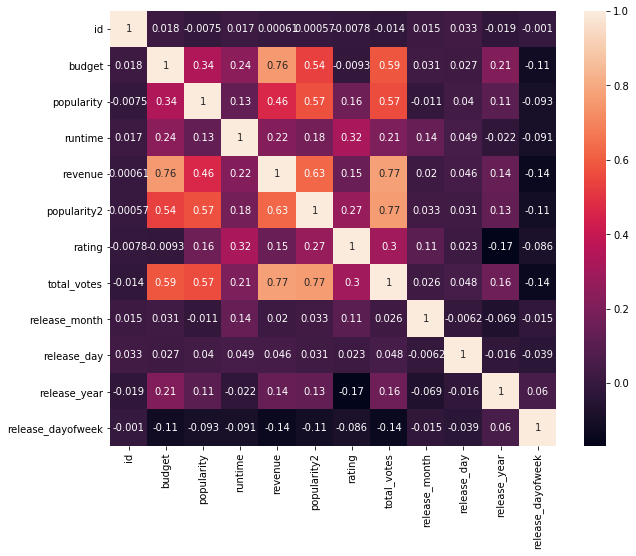

In [12]:
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(train.corr(), annot=True)
plt.show()

## Feature Engineering

In [13]:
def prepare_data(df):
    
    def get_dictionary(s):
        try:
            d = ast.literal_eval(s)
        except ValueError as err:
            d = {}    
        return d

    #Get values of there three features
    def get_company(movie):
        try:
            company_df = pd.DataFrame(get_dictionary(movie.production_companies))
            company_df['id'] = movie.id
            return(company_df)
        except:
            print("bad company list string error in movie with id: {}".format(movie.id))
            
    def get_genre(movie):
        try:
            genre_df = pd.DataFrame(get_dictionary(movie.genres))
            genre_df['id'] = movie.id
            return(genre_df)
        except:
            print("bad genre list string error in movie with id: {}".format(movie.id))
            
    def get_country(movie):
        try:
            country_df = pd.DataFrame(get_dictionary(movie.production_countries))
            country_df['id'] = movie.id
            return(country_df)
        except:
            print("bad crew list string error in movie with id: {}".format(movie.id))

    all_genres = get_genre(df.iloc[0, :])    
    for row in df.itertuples():    
        all_genres = pd.concat([all_genres, get_genre(row)], ignore_index=True, sort=False)

    all_companies = get_company(df.iloc[0, :])   
    for row in df.itertuples():    
        all_companies = pd.concat([all_companies, get_company(row)], ignore_index=True, sort=False) 
        
    all_countries = get_country(df.iloc[0, :])   
    for row in df.itertuples():    
        all_countries = pd.concat([all_countries, get_country(row)], ignore_index=True, sort=False)
        
    company_name = all_companies.rename(columns={'name' : 'name_of_company'})\
                            .drop_duplicates(subset='id', keep='first')\
                            .set_index('id')
    
    genre = all_genres.rename(columns={'name' : 'movie_genre'})\
                            .drop_duplicates(subset='id', keep='first')\
                            .set_index('id')
    
    production_country = all_countries.rename(columns={'iso_3166_1' : 'country'})\
                            .drop_duplicates(subset='id', keep='first')\
                            .set_index('id')
    
    #Number of cast for each row
    df.loc[df["cast"].notnull(),"cast"] = df.loc[df["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
    df.loc[df["cast"].notnull(),"cast"] = df.loc[df["cast"].notnull(),"cast"]\
                                                           .apply(lambda x : [y["name"] for y in x if y["order"]>=0]) 
    df['number_of_cast'] = df['cast'][df['cast'].notnull()].map(lambda x: len(x))

    #Count number of items for each feature
    number_of_feats = ['genres', 'spoken_languages', 'production_companies', 'production_countries', 'Keywords', 'crew']
    PREFFIX_NUMBER = 'number_of_'

    for feat in df[number_of_feats]:
        df.loc[df[feat].notnull(),feat] = df.loc[df[feat].notnull(),feat].apply(lambda x : ast.literal_eval(x))
        number_values = df[feat][df[feat].notnull()].map(lambda x: len(x))
        if PREFFIX_NUMBER in feat:
            df[feat] = number_values
        else:
            df[PREFFIX_NUMBER + feat] = number_values
            
    #Get Month, Day, Year and Week day from release date
    df[['release_month', 'release_day', 'release_year']] = df['release_date'].str.split('/', expand=True).replace(np.nan, 0).astype('int32')
    df.loc[(df['release_year']<=19) & (df['release_year']<100), 'release_year'] += 2000
    df.loc[(df['release_year']>19) & (df['release_year']<100), 'release_year'] += 1900
    releaseDate = pd.to_datetime(df['release_date']) 
    df['release_dayofweek'] = releaseDate.dt.dayofweek
    
    
    df.set_index('id', inplace=True)
    df = pd.merge(df, genre['movie_genre'], left_index=True, right_index=True, how='left')
    df = pd.merge(df, company_name['name_of_company'], left_index=True, right_index=True, how='left')
    df = pd.merge(df, production_country['country'], left_index=True, right_index=True, how='left')
    
    #Filling missing values
    df['country'].fillna(df['original_language'].str.upper().str.replace("EN", "US"), inplace=True)   
    df.loc[df['budget'] == 0, 'budget'] = df['budget'].median()
    num_feats = ['number_of_genres', 'number_of_spoken_languages', 'number_of_production_countries', 
                 'number_of_Keywords', 'popularity2']
    df[num_feats] = df[num_feats].fillna(df[num_feats].median()).astype('int32') 
    df['rating'] = df['rating'].fillna(1.8)
    df['total_votes'] = df['total_votes'].fillna(8)
    df['number_of_production_companies'] = df['number_of_production_companies'].fillna(1).astype('int32') 

    df['inflation_budget'] = df['budget'] + df['budget']*1.8/100*(2018-df['release_year'])

    #Log transform
    df['budget'] = np.log1p(df['budget'])
    df['popularity'] = np.log1p(df['popularity'])
    df['inflation_budget'] = np.log1p(df['inflation_budget'])
    df['total_votes'] = np.log1p(df['total_votes'])
    
    #Get ratio of features
    df['budget_total_votes_ratio'] = df['budget']/df['total_votes'] 
    df['budget_year_ratio'] = df['budget']/df['release_year']
    df['total_votes_year_ratio'] = df['total_votes']/df['release_year']
    
    #Bool transform
    df['has_collection'] = np.where(df['belongs_to_collection'].isna(), 0, 1)
    df['has_homepage'] = np.where(df['homepage'].isna(), 0, 1)

    #Label encoding for features
    feats = ['movie_genre', 'name_of_company', 'country']
    SUFFIX_CAT = '__cat'

    for feat in df[feats]:
        factorized_values = df[feat].factorize()[0]
        if SUFFIX_CAT in feat:
            df[feat] = factorized_values
        else:
            df[feat + SUFFIX_CAT] = factorized_values
            
            
    df.drop(columns=['title', 'original_language', 'status', 'movie_genre', 'belongs_to_collection', 'genres',
                     'imdb_id', 'original_title', 'overview', 'homepage',
                     'spoken_languages', 'poster_path', 'production_companies', 'production_countries', 'tagline',
                     'Keywords', 'cast', 'crew', 'release_date', 'name_of_company', 'country'], inplace=True)
    
    return df

In [14]:
train = prepare_data(train)
test = prepare_data(test)

__Clean more data__

In [15]:
train.loc[519, ['number_of_cast', 'number_of_crew']] = 74, 197     #Wonder Woman
train.loc[681, ['number_of_cast', 'number_of_crew']] = 35, 285     #The Day After Tomorrow
train.loc[907, ['number_of_cast', 'number_of_crew']] = 163, 218    #The Dark Knight Rises
train.loc[935, ['number_of_cast', 'number_of_crew']] = 66, 196     #John Wick: Chapter 2
train.loc[1304, ['number_of_cast', 'number_of_crew']] = 213, 31    #Mr. Smith Goes to Washington
train.loc[1618, ['number_of_cast', 'number_of_crew']] = 29, 217    #The Assassination of Richard Nixon
train.loc[1784, ['number_of_cast', 'number_of_crew']] = 95, 238    #Logan
train.loc[2015, ['number_of_cast', 'number_of_crew']] = 139, 224   #The Wolf of Wall Street
train.loc[2449, ['number_of_cast', 'number_of_crew']] = 86, 328    #15 Minutes
train.loc[2519, ['number_of_cast', 'number_of_crew']] = 183, 37    #You Don't Mess with the Zohan
train.loc[2624, ['number_of_cast', 'number_of_crew']] = 118, 315   #Valerian and the City of a Thousand Planets
train.loc[2884, ['number_of_cast', 'number_of_crew']] = 42, 145    #The X Files: I Want to Believe
train.loc[2966, ['number_of_cast', 'number_of_crew']] = 15, 22     #Les Misérables

test.loc[3229, ['number_of_cast', 'number_of_crew']] = 73, 231     #Daredevil
test.loc[3760, ['number_of_cast', 'number_of_crew']] = 223, 15     #Rock of Ages
test.loc[4935, ['number_of_cast', 'number_of_crew']] = 30, 409     #Jurassic World
test.loc[5463, ['number_of_cast', 'number_of_crew']] = 161, 116    #Fantastic Beasts and Where to Find Them
test.loc[5650, ['number_of_cast', 'number_of_crew']] = 54, 270     #The Core
test.loc[5762, ['number_of_cast', 'number_of_crew']] = 19, 248     #The Chronicles of Riddick
test.loc[5804, ['number_of_cast', 'number_of_crew']] = 168, 391    #Star Trek
test.loc[6414, ['number_of_cast', 'number_of_crew']] = 53, 418     #Monsters, Inc.
test.loc[6479, ['number_of_cast', 'number_of_crew']] = 143, 266    #Real Steel
test.loc[6515, ['number_of_cast', 'number_of_crew']] = 50, 203     #The Dark Tower
test.loc[6526, ['number_of_cast', 'number_of_crew']] = 204, 120    #Jason Bourne
test.loc[6873, ['number_of_cast', 'number_of_crew']] = 313, 52     #Around the World in Eighty Day

In [16]:
train['number_of_crew'] = train['number_of_crew'].fillna(train['number_of_crew'].median()).astype('int32')
test['number_of_crew'] = test['number_of_crew'].fillna(test['number_of_crew'].median()).astype('int32')
test['number_of_cast'] = test['number_of_cast'].fillna(test['number_of_cast'].median()).astype('int32')
train['number_of_cast'] = np.log1p(train['number_of_cast'])
test['number_of_cast'] = np.log1p(test['number_of_cast'])

## Feature Importance

In [17]:
feat_names = train.drop(columns='revenue').columns.values

X = train[feat_names].values
y = train['revenue'].values

m = xgb.XGBRegressor(colsample_bytree = 0.8,
                     learning_rate = 0.1,
                     max_depth = 7,
                     n_estimators = 100,)
m.fit(X, y)

imp = PermutationImportance(m, random_state=0).fit(X, y)
eli5.show_weights(imp, feature_names=feat_names, top=100)

Weight,Feature
0.2860 ± 0.0072,total_votes_year_ratio
0.1953 ± 0.0078,total_votes
0.1847 ± 0.0160,inflation_budget
0.0638 ± 0.0052,budget_year_ratio
0.0373 ± 0.0026,budget
0.0290 ± 0.0048,has_collection
0.0183 ± 0.0081,release_month
0.0170 ± 0.0022,release_year
0.0152 ± 0.0016,rating
0.0148 ± 0.0018,number_of_cast


## Hyperparameter optimazation

In [18]:
feats = train.drop(columns='revenue').columns.values

In [19]:
def run_model(model, feats):
    X = train[feats].values
    y = train['revenue'].values
    
    scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
    return np.mean(scores)

In [21]:
def obj_func(params):
    print("Training with params: ")
    print(params)

    mean_mae = run_model(xgb.XGBRegressor(**params), feats)

    return {'loss': np.abs(mean_mae), 'status': STATUS_OK}

#space
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate', np.arange(0.05, 0.31, 0.05)),
    'n_estimators':     hp.choice('n_estimators', np.arange(100, 500, 1)),
    'max_depth':        hp.choice('max_depth',     np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'eta':              hp.quniform('eta', 0.025, 0.5, 0.025),
    'subsample':        hp.quniform('subsample', 0.5, 1, 0.05),
    'gamma':            hp.quniform('gamma', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'objective':        'reg:squarederror',
    'seed': 0,
}

#run
best = fmin(obj_func, xgb_reg_params, algo=tpe.suggest, max_evals=25, return_argmin=False)

best

Training with params:                                 
{'colsample_bytree': 0.6000000000000001, 'eta': 0.42500000000000004, 'gamma': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4.0, 'n_estimators': 352, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.55}
Training with params:                                                           
{'colsample_bytree': 0.8500000000000001, 'eta': 0.275, 'gamma': 0.8500000000000001, 'learning_rate': 0.25, 'max_depth': 7, 'min_child_weight': 3.0, 'n_estimators': 423, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.5}
Training with params:                                                           
{'colsample_bytree': 0.5, 'eta': 0.15000000000000002, 'gamma': 0.6000000000000001, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 2.0, 'n_estimators': 269, 'objective': 'reg:squarederror', 'seed': 0, 'subsample': 0.8500000000000001}
Training with params:                                                        

{'colsample_bytree': 0.65,
 'eta': 0.325,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 1.0,
 'n_estimators': 153,
 'objective': 'reg:squarederror',
 'seed': 0,
 'subsample': 0.8500000000000001}

## Build model

In [22]:
xgb_params = {'colsample_bytree': 0.65,
 'eta': 0.325,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 1.0,
 'n_estimators': 153,
 'objective': 'reg:squarederror',
 'seed': 0,
 'subsample': 0.8500000000000001}

In [23]:
X = train.drop(['revenue'], axis = 1)
y = np.log1p(train['revenue'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

In [24]:
xgb_data = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]

In [25]:
xgb_model = xgb.train(xgb_params, 
                      xgb.DMatrix(X_train, y_train),
                      5000,  
                      xgb_data, 
                      verbose_eval=20,
                      early_stopping_rounds=200)

[14:25:55] WARNING: /workspace/src/learner.cc:328: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:15.05176	valid-rmse:14.73804
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[20]	train-rmse:5.68844	valid-rmse:5.56258
[40]	train-rmse:2.53333	valid-rmse:2.72578
[60]	train-rmse:1.59915	valid-rmse:2.13184
[80]	train-rmse:1.30122	valid-rmse:2.04594
[100]	train-rmse:1.17498	valid-rmse:2.03387
[120]	train-rmse:1.07369	valid-rmse:2.03257
[140]	train-rmse:0.99108	valid-rmse:2.03172
[160]	train-rmse:0.92139	valid-rmse:2.03161
[180]	train-rmse:0.85577	valid-rmse:2.03370
[200]	train-rmse:0.79518	valid-rmse:2.03682
[220]	train-rmse:0.74492	valid-rms

## Submission

In [26]:
X_test = test[feat_names]
xgb_pred = np.expm1(xgb_model.predict(xgb.DMatrix(X_test), ntree_limit=xgb_model.best_ntree_limit))
pd.DataFrame({'id': test.index, 'revenue': xgb_pred}).to_csv('./TMDB_pred/XGBoost.csv', index=False)